# Instalación e importación de librerías

In [ ]:
pip install pyet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pyet.radiation import hargreaves,fao_24
from pyet.combination import pm_fao56
from pyet.temperature import hamon
from pyet.meteo_utils import extraterrestrial_r
import pandas as pd
import numpy as np
import datetime

# Trabajando con el set de datos de Agrometeorología.cl (Estación meteorológica Pudahuel)

## Definición de constantes a utilizar

In [ ]:
DEG_TO_RAD_CONSTANT = 0.01745329251
KMH_TO_MS_CONSTANT = 1/3.6
MBAR_TO_KPA_CONSTANT = 1/10
lat = -33.3971255
elevation = 482.0
lat_rad = float(lat) *  DEG_TO_RAD_CONSTANT
RUTA = '/content/drive/MyDrive/Universidad/et0 2022/data_processing/'

## Creación de dataframes a partir del set de datos

In [ ]:
datasets = ['rh_minmax','t_minmax','temp-wind-rs-rh-pressure','et0_ref']
df_new = pd.DataFrame()
for i in datasets:
  df = pd.read_csv(RUTA+"data/"+i+".csv",quotechar="'",keep_default_na=True)
  df.date = pd.to_datetime(df.date,format="%d-%m-%Y")
  df = df.set_index("date")
  df = df.interpolate()
  df = df.resample(rule='D').mean().copy()
  if i == 'rh_minmax':
    df_new = pd.concat([df_new,df[["rhmin","rhmax"]]],axis=1)
  elif i == 't_minmax':
    df_new = pd.concat([df_new,df[["tmin","tmax"]]],axis=1)
  elif i == 'temp-wind-rs-rh-pressure':
    df_new = pd.concat([df_new,df[["temp","wind","rs","rh","pressure"]]],axis=1)
  elif i == 'et0_ref':
    df_new = pd.concat([df_new,df[["et0"]]],axis=1)
df_2 = df_new.copy()
df_2["ra"] = extraterrestrial_r(df_2.index,lat_rad)
df_2["et0_pmfao56"] = pm_fao56(df_2.temp , df_2.wind * KMH_TO_MS_CONSTANT , rs = df_2.rs , rh = df_2.rh , tmax = df_2.tmax , tmin = df_2.tmin , pressure = df_2.pressure * MBAR_TO_KPA_CONSTANT , lat = lat_rad , elevation = elevation , rhmin = df_2.rhmin , rhmax = df_2.rhmax)
df_2["et0_hs"] = hargreaves(tmean = df_2.temp , tmin = df_2.tmin , tmax = df_2.tmax , lat = lat_rad)
df_2["et0_fao24"] = fao_24(tmean = df_2.temp , wind = df_2.wind * KMH_TO_MS_CONSTANT , rs = df_2.rs , rh = df_2.rh , pressure = df_2.pressure * MBAR_TO_KPA_CONSTANT , elevation = elevation)
df_2["et0_hamon"] = hamon(tmean = df_2.temp , lat = lat_rad)
df_2

,rhmin,rhmax,tmin,tmax,temp,wind,rs,rh,pressure,et0,ra,et0_pmfao56,et0_hs,et0_fao24,et0_hamon
date,,,,,,,,,,,,,,,
2021-01-01,28.5,62.5,16.0,28.9,22.4,16.8,33.3,45.5,958.0,8.70,44.121240,8.632600,5.985010,8.036877,5.649906
2021-01-02,34.3,78.3,14.1,28.7,21.4,18.3,31.8,56.3,959.0,8.00,44.085443,7.931729,6.197768,7.211374,5.300904
2021-01-03,25.2,77.4,14.6,30.8,22.7,16.6,33.6,51.3,959.0,9.00,44.046287,8.882684,6.747514,7.900403,5.741748
2021-01-04,27.8,69.7,15.5,30.3,22.9,16.6,33.4,48.8,957.0,8.90,44.003771,8.779747,6.476210,7.984197,5.805459
2021-01-05,25.4,73.2,12.0,28.4,20.2,18.2,33.6,49.3,958.0,8.60,43.957896,8.519092,6.341883,7.762737,4.896315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-31,28.7,81.9,-2.5,13.8,5.6,7.4,12.0,55.3,961.0,1.95,17.500984,1.928804,1.528580,1.482265,0.975372
2022-06-01,43.6,82.2,-1.9,12.1,5.1,7.0,11.6,62.9,963.0,1.56,17.410010,1.527526,1.378506,1.315102,0.942555
2022-06-02,61.1,95.6,4.8,12.3,8.6,5.3,8.0,78.4,963.0,1.07,17.323257,1.076585,1.161231,0.792503,1.169694


# Trabajando con la predicción del clima

In [ ]:
df_prueba = pd.read_csv(RUTA+"data/01-06-2022 Pudahuel Forecast (Weather.com Scraping).csv",quotechar="'",na_values='0',keep_default_na=True)
df_prueba.date = pd.to_datetime(df_prueba.date,format="%d-%m-%Y")
df_prueba = df_prueba.set_index("date")
df_prueba = df_prueba[["weather_condition","rs_real","t_min","t_max","humidity_day","wind_speed","sunshine_duration"]]
cod = []
for i in df_prueba['weather_condition']:
  if i=='Parcialmente nublado':
    cod.append(0.6)
  elif i=='Lluvia':
    cod.append(0.05)
  elif i=='Nublado':
    cod.append(0.5)
  elif i=='Mayormente soleado':
    cod.append(0.8)
  elif i=='Muy nublado':
    cod.append(0.4)
df_cod = pd.DataFrame(cod)
df_prueba["weather_cond_cod"] = cod

for i in range(len(df_prueba.sunshine_duration)):
 df_prueba.sunshine_duration[i] = df_prueba.sunshine_duration[i][7:]
df_prueba.sunshine_duration = pd.to_datetime(df_prueba.sunshine_duration,infer_datetime_format=True)
sunshine_duration_flt = []
for i in range(len(df_prueba.sunshine_duration)):
  sunshine_duration_flt.append((df_prueba['sunshine_duration'][i] - datetime.datetime.combine(df_prueba['sunshine_duration'][i].date(), datetime.time())).total_seconds()/3600)

df_prueba["sunshine_duration_float"] = sunshine_duration_flt

df_prueba["ra"] = extraterrestrial_r(df_prueba.index,lat_rad)
df_prueba["rs_est"] = df_prueba['ra']*df_prueba['weather_cond_cod']
df_prueba
# df_2["et0_pmfao56"] = pm_fao56(df_2.temp , df_2.wind * KMH_TO_MS_CONSTANT , rs = df_2.rs , rh = df_2.rh , tmax = df_2.tmax , tmin = df_2.tmin, lat = lat_rad , elevation = elevation)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,weather_condition,rs_real,t_min,t_max,humidity_day,wind_speed,sunshine_duration,weather_cond_cod,sunshine_duration_float,ra,rs_est
date,,,,,,,,,,,
2022-06-01,Parcialmente nublado,11.6,3°,12°,66%,SO 14 km/h,2022-06-27 10:05:00,0.60,10.083333,17.410010,10.446006
2022-06-02,Parcialmente nublado,8.0,5°,14°,74%,SE 11 km/h,2022-06-27 10:04:00,0.60,10.066667,17.323257,10.393954
2022-06-03,Lluvia,0.8,5°,11°,84%,ESE 12 km/h,2022-06-27 10:03:00,0.05,10.050000,17.240746,0.862037
2022-06-04,Muy nublado,4.1,6°,13°,85%,ESE 10 km/h,2022-06-27 10:02:00,0.40,10.033333,17.162499,6.864999
2022-06-05,Mayormente soleado,8.2,4°,15°,77%,SE 10 km/h,2022-06-27 10:01:00,0.80,10.016667,17.088531,13.670825
2022-06-06,Mayormente soleado,12.2,5°,17°,63%,SE 11 km/h,2022-06-27 10:01:00,0.80,10.016667,17.018862,13.615090
2022-06-07,Mayormente soleado,11.4,3°,16°,62%,SE 12 km/h,2022-06-27 10:00:00,0.80,10.000000,16.953506,13.562805
2022-06-08,Muy nublado,9.9,5°,18°,60%,ESE 12 km/h,2022-06-27 10:00:00,0.40,10.000000,16.892478,6.756991
2022-06-09,Nublado,6.5,6°,19°,47%,SE 11 km/h,2022-06-27 09:59:00,0.50,9.983333,16.835792,8.417896


# Comparación de las Fórmulas de estimación para la ET0

r2: 0.9919907279993297
variables: tmean,tmin,tmax,lat,wind_speed,rs,rh,rhmin,rhmax,pressure,elevation


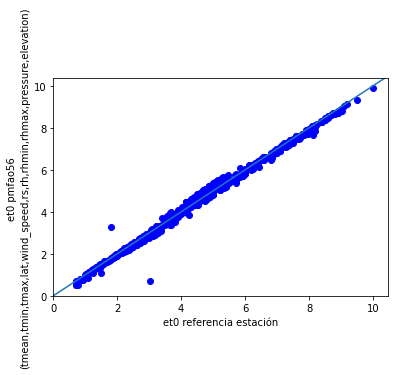

In [ ]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt 
df_plt = df_2[["et0","et0_pmfao56",'et0_hs','et0_fao24','et0_hamon']]
print('r2:',r2_score(df_plt.et0, df_plt.et0_pmfao56))
print('variables: tmean,tmin,tmax,lat,wind_speed,rs,rh,rhmin,rhmax,pressure,elevation')
plt.scatter(df_plt.et0, df_plt.et0_pmfao56,color='b')
plt.xlabel('et0 referencia estación')
plt.ylabel('et0 pmfao56 \n(tmean,tmin,tmax,lat,wind_speed,rs,rh,rhmin,rhmax,pressure,elevation)')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
graph = plt.plot([-100, 100], [-100, 100])

r2: 0.6970691258780584
variables: tmean,tmin,tmax,lat


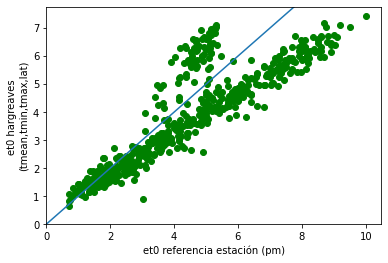

In [ ]:
print('r2:',(r2_score(df_plt.et0, df_plt.et0_hs)))
print('variables: tmean,tmin,tmax,lat')
plt.scatter(df_plt.et0, df_plt.et0_hs,color='g')
plt.xlabel('et0 referencia estación (pm)')
plt.ylabel('et0 hargreaves \n(tmean,tmin,tmax,lat)')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
graph = plt.plot([-100, 100], [-100, 100])

r2: 0.7755553937984717
variables: tmean,wind_speed,rs,rh,pressure,elevation


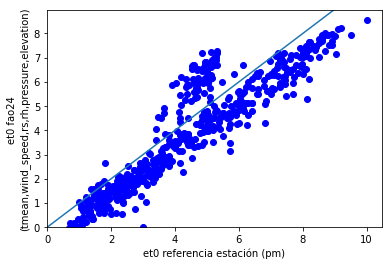

In [ ]:
print('r2:',r2_score(df_plt.et0, df_plt.et0_fao24))
print('variables: tmean,wind_speed,rs,rh,pressure,elevation')
plt.scatter(df_plt.et0, df_plt.et0_fao24,color='b')
plt.xlabel('et0 referencia estación (pm)')
plt.ylabel('et0 fao24 \n(tmean,wind_speed,rs,rh,pressure,elevation)')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
graph = plt.plot([-100, 100], [-100, 100])

r2: 0.24614342185164506
variables: tmean,lat


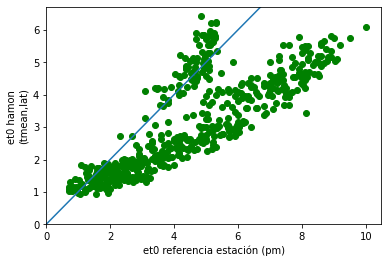

In [ ]:
print('r2:',r2_score(df_plt.et0, df_plt.et0_hamon))
print('variables: tmean,lat')
plt.scatter(df_plt.et0, df_plt.et0_hamon,color='g')
plt.xlabel('et0 referencia estación (pm)')
plt.ylabel('et0 hamon \n(tmean,lat)')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
graph = plt.plot([-100, 100], [-100, 100])

r2 -2.888699358911062


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


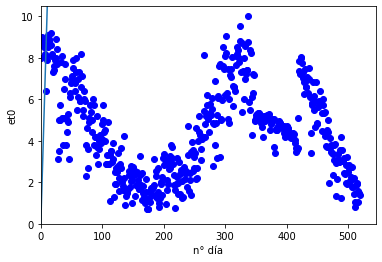

In [ ]:
df_test = df_2[['et0']]
nums = []
for i in range(len(df_test)):
  nums.append(i)
df_test["nums"] = nums.copy()

print('r2',r2_score(df_test.nums,df_2.et0))
plt.scatter(df_test.nums,df_test.et0,color = 'b')
plt.xlabel('n° día')
plt.ylabel('et0')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
# graph = plt.plot([-100,100], [-100,100])

# Guardando el dataframe trabajado a un CSV

In [ ]:
df_2.to_csv(RUTA+"data/Pudahuel01-01-2021--04-06-2022_.csv")